<a href="https://colab.research.google.com/github/CyberMaryVer/detectron-doc/blob/master/Facebook_3D_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VideoPose3D

Inference in the wild

* https://github.com/facebookresearch/VideoPose3D/blob/master/INFERENCE.md

Let's get the model files and a test image.

In [1]:
!git clone https://github.com/facebookresearch/detectron2
!git clone https://github.com/facebookresearch/VideoPose3D
!wget https://dl.fbaipublicfiles.com/video-pose-3d/pretrained_h36m_detectron_coco.bin -P /content/VideoPose3D/checkpoint/
!wget https://sarajevo.travel/assets/photos/events/original/balkan-health-amp-fitness-summit-1540381827.jpg -q -O input.jpg

--2021-03-05 16:09:18--  https://dl.fbaipublicfiles.com/video-pose-3d/pretrained_h36m_detectron_coco.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67892577 (65M) [application/octet-stream]
Saving to: ‘pretrained_h36m_detectron_coco.bin’

pretrained_h36m_det 100%[===================>]  64.75M  22.6MB/s    in 2.9s    

2021-03-05 16:09:22 (22.6 MB/s) - ‘pretrained_h36m_detectron_coco.bin’ saved [67892577/67892577]



# Inference for image

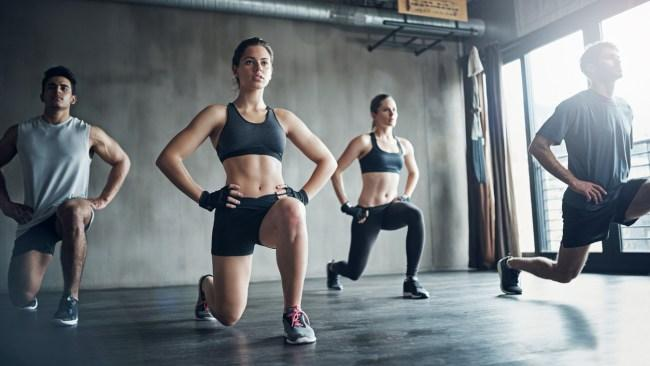

In [62]:
from google.colab.patches import cv2_imshow
im = cv2.imread("/content/input.jpg")
cv2_imshow(im)

# Inference for video

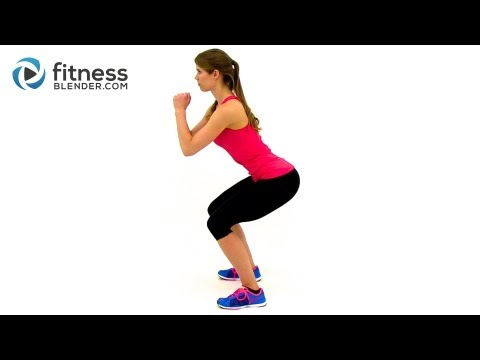

In [2]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("mGvzVjuY8SY", width=500)
display(video)

In [5]:
!pip install youtube-dl
!pip install ffmpeg
!youtube-dl https://www.youtube.com/watch?v=mGvzVjuY8SY -f 22 -o video_.mp4
!mkdir test
!ffmpeg -i video_.mp4 -ss 00:00:47 -t 5 -c:v copy video.mp4
!rm video_.mp4

[youtube] mGvzVjuY8SY: Downloading webpage
[download] video_.mp4 has already been downloaded
[download] 100% of 29.63MiB
mkdir: cannot create directory ‘test’: File exists
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --

In [4]:
# !ffmpeg -i video_.mp4 -filter "minterpolate='fps=50'" -crf 0 input.mp4

# Set up Detectron2

In [5]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# !pip install -U 'git+https://github.com/facebookresearch/iopath'

     |████████████████████████████████| 276kB 10.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=fc1476ac40d9e38fcada39155c292f7e142dfcb8aded71a8835db3549d212c53
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 694kB/s 
     |████████████████████████████████| 2.2MB 18.3MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
  Created wheel for

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")) # we can change the path here
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml") # we can change the path here
predictor = DefaultPredictor(cfg)

In [84]:
!python /content/VideoPose3D/inference/infer_video_d2.py --help

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

usage: infer_video_d2.py [-h] [--cfg CFG] [--output-dir OUTPUT_DIR]
                         [--image-ext IMAGE_EXT]
                         im_or_folder

End-to-end inference

positional arguments:
  im_or_folder          image or folder of images

optional arguments:
  -h, --help            show this help message and exit
  --cfg CFG             cfg model file (/path/to/model_config.yaml)
  --output-dir OUTPUT_DIR
                        directory for visualization pdfs (default:
                        /tmp/infer_simple)
  --image-ext IMAGE_EXT
                        image file name extension (default: mp4)


In [87]:
!python /content/VideoPose3D/inference/infer_video_d2.py /content/input.jpg \
    --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
    --output-dir /content/ \
    --image-ext jpg

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

Processing /content/input.jpg
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-li

In [57]:
!python /content/VideoPose3D/inference/infer_video_d2.py \
    --cfg COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml \
    --output-dir /content/ \
    --image-ext mp4 \
    /content/

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

Processing /content/video.mp4
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-li

In [92]:
os.chdir('/content/VideoPose3D/data/')
!python prepare_data_2d_custom.py -i /content/ -o myvideos

Parsing 2D detections from /content/
Processing /content/video.mp4.npz
121 total frames processed
0 frames were interpolated
----------
Processing /content/input.jpg.npz
1 total frames processed
0 frames were interpolated
----------
Saving...
Done.


In [63]:
!python run.py --help

usage: run.py [-h] [-d NAME] [-k NAME] [-str LIST] [-ste LIST] [-sun LIST]
              [-a LIST] [-c PATH] [--checkpoint-frequency N] [-r FILENAME]
              [--evaluate FILENAME] [--render] [--by-subject]
              [--export-training-curves] [-s N] [-e N] [-b N] [-drop P]
              [-lr LR] [-lrd LR] [-no-da] [-no-tta] [-arc LAYERS] [--causal]
              [-ch N] [--subset FRACTION] [--downsample FACTOR] [--warmup N]
              [--no-eval] [--dense] [--disable-optimizations]
              [--linear-projection] [--no-bone-length] [--no-proj]
              [--viz-subject STR] [--viz-action STR] [--viz-camera N]
              [--viz-video PATH] [--viz-skip N] [--viz-output PATH]
              [--viz-export PATH] [--viz-bitrate N] [--viz-no-ground-truth]
              [--viz-limit N] [--viz-downsample N] [--viz-size N]

Training script

optional arguments:
  -h, --help            show this help message and exit
  -d NAME, --dataset NAME
                        target da

In [64]:
import os
os.chdir('/content/VideoPose3D/')
!python run.py -d custom -k myvideos -arc 3,3,3,3,3 -c checkpoint \
--evaluate pretrained_h36m_detectron_coco.bin \
--render \
--viz-subject video.mp4 --viz-action custom \
--viz-camera 0 \
--viz-video /content/video.mp4 \
--viz-output output2.mp4 \
--viz-size 6 \
--viz-export /content/coords.mp4

Namespace(actions='*', architecture='3,3,3,3,3', batch_size=1024, bone_length_term=True, by_subject=False, causal=False, channels=1024, checkpoint='checkpoint', checkpoint_frequency=10, data_augmentation=True, dataset='custom', dense=False, disable_optimizations=False, downsample=1, dropout=0.25, epochs=60, evaluate='pretrained_h36m_detectron_coco.bin', export_training_curves=False, keypoints='myvideos', learning_rate=0.001, linear_projection=False, lr_decay=0.95, no_eval=False, no_proj=False, render=True, resume='', stride=1, subjects_test='S9,S11', subjects_train='S1,S5,S6,S7,S8', subjects_unlabeled='', subset=1, test_time_augmentation=True, viz_action='custom', viz_bitrate=3000, viz_camera=0, viz_downsample=1, viz_export='/content/coords.mp4', viz_limit=-1, viz_no_ground_truth=False, viz_output='output2.mp4', viz_size=6, viz_skip=0, viz_subject='video.mp4', viz_video='/content/video.mp4', warmup=1)
Loading dataset...
Preparing data...
Loading 2D detections...
INFO: Receptive field: 

In [98]:
!mv /content/VideoPose3D/output.mp4 /content/output.mp4

In [99]:
from IPython.display import HTML
from base64 import b64encode

# Input video path
save_path = "/content/output.mp4"
# Compressed video path
compressed_path = "/content/output_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Keypoints

In [88]:
import numpy as np

data = np.load('/content/input.jpg.npz', allow_pickle=True)

In [65]:
data2 = np.load("/content/coords.mp4.npy")

In [67]:
data2.shape

(121, 17, 3)

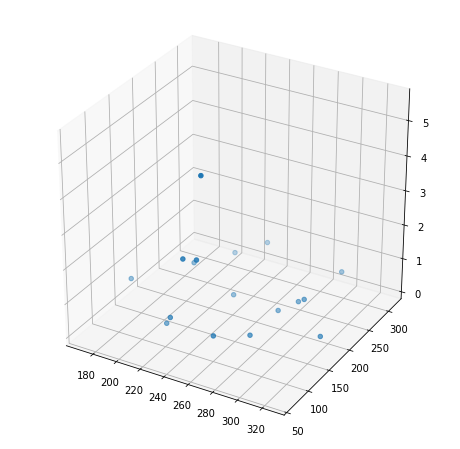

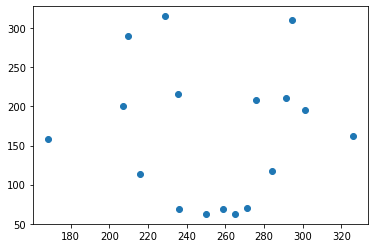

[[2.5869992e+02 2.6503531e+02 2.4992778e+02 2.7137076e+02 2.3628224e+02
  2.8404160e+02 2.1581395e+02 3.2595285e+02 1.6854193e+02 3.0109848e+02
  2.0704181e+02 2.7575681e+02 2.3530756e+02 2.9135172e+02 2.2897212e+02
  2.9427573e+02 2.0947852e+02]
 [5.8139896e+01 6.4464737e+01 5.2301582e+01 7.3222214e+01 4.3057583e+01
  8.9764114e+01 2.1163897e+01 1.2284790e+02 2.4326317e-01 1.0435990e+02
  7.0546322e+00 7.5168320e+01 3.4786633e+01 7.2735687e+01 2.1163897e+01
  7.1276108e+01 4.0624950e+01]
 [3.9249155e+02 3.9443890e+02 3.8616272e+02 3.9735992e+02 3.7447864e+02
  4.0417560e+02 3.6230777e+02 4.1342548e+02 3.3553183e+02 4.0612299e+02
  3.4478168e+02 3.9297839e+02 3.6863663e+02 4.1634650e+02 3.5451837e+02
  4.1099130e+02 3.3358444e+02]
 [6.1857288e+02 6.1857288e+02 6.1175146e+02 6.1857288e+02 5.9128711e+02
  6.2198358e+02 5.7569525e+02 6.2539429e+02 5.3866467e+02 5.7569525e+02
  5.7520801e+02 6.1028967e+02 5.8787640e+02 5.6546313e+02 5.6546313e+02
  5.1332788e+02 5.1332788e+02]]
[[ 68.38248

In [91]:
x = data['keypoints'][0][1][:,0][0]
y = data['keypoints'][0][1][:,1][0]
z = data['keypoints'][0][1][:,3][0]

# x = data2[0][:,0]
# y = data2[0][:,1]
# z = data2[0][:,2]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)
plt.show()

plt.scatter(x,y)
plt.show()

print(data['keypoints'][0][1][:,0])
print(data['keypoints'][0][1][:,1])
print(data['keypoints'][0][1][:,2])
print(data['keypoints'][0][1][:,3])

In [46]:
T# data['keypoints'][0][1].shape
# data['boxes'][0][1]
data["metadata"]

array({'w': 1280, 'h': 720}, dtype=object)

In [44]:
data['boxes'].shape, data['keypoints'].shape

((121, 2), (121, 2))

In [83]:
data2[0], data2.shape

(array([[-4.29744250e-06, -3.27137168e-05,  2.75962930e-06],
        [-1.21412247e-01,  3.38732149e-04,  6.41999245e-02],
        [-3.60541105e-01,  4.83727828e-02, -3.11590910e-01],
        [-2.19388098e-01,  3.50504786e-01, -1.05778679e-01],
        [ 1.21414334e-01, -3.52914154e-04, -6.41882792e-02],
        [-2.25662775e-02,  1.01479046e-01, -4.76297200e-01],
        [ 8.13385099e-02,  3.91519576e-01, -2.82522053e-01],
        [-9.13490653e-02, -1.44413233e-01, -1.76001012e-01],
        [-1.86957374e-01, -2.77641416e-01, -3.73395026e-01],
        [-2.38846749e-01, -3.25802982e-01, -4.66788590e-01],
        [-2.09062606e-01, -4.28675294e-01, -4.16361868e-01],
        [-5.79645857e-02, -2.14956135e-01, -4.16648090e-01],
        [-8.76605436e-02,  4.97636013e-02, -5.36538482e-01],
        [-2.36701950e-01, -1.57847553e-01, -5.31811237e-01],
        [-3.04010034e-01, -2.41648793e-01, -2.92377353e-01],
        [-4.04341102e-01,  5.83902001e-03, -3.65973890e-01],
        [-2.96342611e-01